# Precipitation Analysis

In [1]:
# Importing dependencies
#*******************************************
import matplotlib
from matplotlib import style
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime as dt
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [2]:
# SQL Connection and attributes
engine = create_engine("sqlite:///hawaii.sqlite", echo=False)
Base = automap_base()
Base.prepare(engine, reflect=True)

In [3]:
# Establishing connection session
session = Session(bind=engine)

In [4]:
# Verify tables and structure from SQLite database
inspector = inspect(engine)
tbl_names = inspector.get_table_names()
i =1 
for table in tbl_names:
    print("Table "+str(i)+": "+str(table))
    i = i+1
    columns = inspector.get_columns(table)
    for col in columns:
        print("     Col: "+str(col["name"])+" ("+str(col["type"])+")")

Table 1: measurement
     Col: id (INTEGER)
     Col: station (TEXT)
     Col: date (TEXT)
     Col: prcp (FLOAT)
     Col: tobs (FLOAT)
Table 2: station
     Col: id (INTEGER)
     Col: station (TEXT)
     Col: name (TEXT)
     Col: latitude (FLOAT)
     Col: longitude (FLOAT)
     Col: elevation (FLOAT)


In [6]:
# Obtaining class information
print(str(inspector.get_pk_constraint("station")))
print(str(inspector.get_pk_constraint("measurement")))

{'constrained_columns': ['id'], 'name': None}
{'constrained_columns': ['id'], 'name': None}


In [7]:
# Assigning table classes
Measurements = Base.classes.measurement
Stations = Base.classes.station

In [10]:
# Creating Precipitation Analysis pandas dataframe to house the "date" and "prcp" values from the "measurements" table
prcp_analysis_df = pd.read_sql("SELECT date, prcp FROM measurement", con=engine, columns=[["date"],["prcp"]])

In [11]:
prcp_analysis_df.head()

,date,prcp
0,2010-01-01,0.08
1,2010-01-02,0.00
2,2010-01-03,0.00
3,2010-01-04,0.00
4,2010-01-06,NaN


In [36]:
# Converting the "date" field into the date data-type
prcp_analysis_df["date"] = pd.to_datetime(prcp_analysis_df["date"])#,format="%Y-%m-%d", errors="coerce")


In [37]:
# Determining the max date and subtracting 365 days to create the minimum date (or the past 12 months)
pa_max_date = prcp_analysis_df["date"].max().date()
pa_today = dt.date.today()
pa_min_date = (pa_max_date - dt.timedelta(days=365))
print("Date Range: "+str(pa_min_date)+" to "+str(pa_max_date))

Date Range: 2016-08-23 to 2017-08-23


In [39]:
# Dropping all records from Precipitation Analysis dataframe that are not within the last 12 months from the max date
prcp_analysis_df = prcp_analysis_df.loc[prcp_analysis_df["date"]>=pa_min_date]
prcp_analysis_df.head()

C:\Users\pinel\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.
  


,date,prcp
2363,2016-08-23,0.00
2364,2016-08-24,0.08
2365,2016-08-25,0.08
2366,2016-08-26,0.00
2367,2016-08-27,0.00


In [40]:
prcp_analysis_df.set_index("date", inplace=True)
prcp_analysis_df.describe(include="all")

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


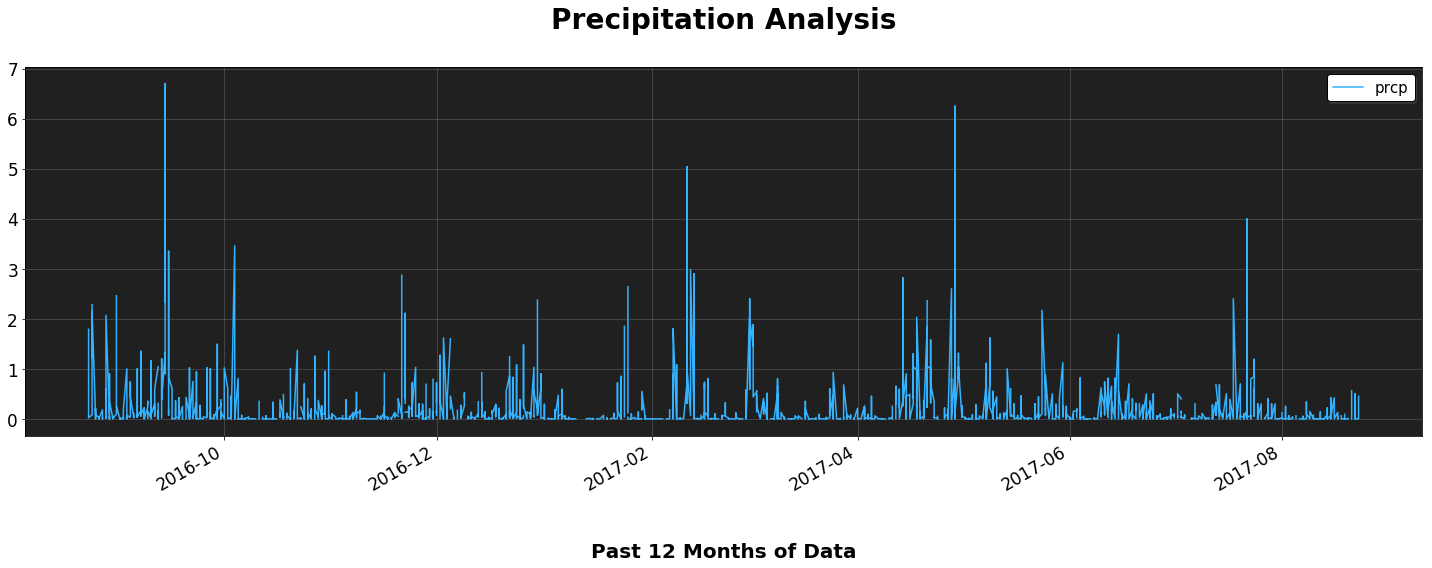

In [41]:
ax = prcp_analysis_df.plot.line(y="prcp",figsize=(20,8), fontsize=17, color="#33B3FF")
ax.patch.set_facecolor("#000000")
ax.set_xlabel(xlabel="\n\nPast 12 Months of Data", fontsize=20, color="#000000", fontweight="bold")
ax.set_frame_on(b=True)
ax.set_facecolor("#202020")
ax.grid(True, alpha=.3)
ax.legend(frameon=True, fancybox=True, facecolor="#FFFFFF", edgecolor="#000000", shadow=True, loc="best", fontsize=15, mode="exapnd")
ax.label_outer()
ax.set_title("Precipitation Analysis\n", fontsize=28, color="#000000", fontweight="bold")
plt.tight_layout()
plt.savefig("prcp_analysis.png")

# Station Analysis

In [43]:
# Counting activity by station data to determine most active station
active_df = pd.read_sql("SELECT s.station, count(m.station) as station_count FROM measurement m, station s \
                  WHERE m.station=s.station GROUP BY m.station", con=engine, columns=[["station"],["station_count"]])

In [44]:
# Sorting the values by highest value count first
active_df.sort_values(by="station_count", ascending=False, inplace=True)

In [45]:
# Settings the "station" as the index
indexed_activity = active_df.set_index("station")

In [46]:
# Dataframe for most active staitons sorted by station count
indexed_activity

,station_count
station,
USC00519281,2772
USC00519397,2724
USC00513117,2709
USC00519523,2669
USC00516128,2612
USC00514830,2202
USC00511918,1979
USC00517948,1372
USC00518838,511


In [47]:
# Finding the highest value of the stations returned
max_activity = indexed_activity.station_count.max()

In [48]:
# Displaying the station name observation count of max_activity query
most_active = list(np.where(indexed_activity["station_count"]==max_activity)[0])
station_max = indexed_activity.iloc[most_active]
station_max =str(station_max.index[0])
print("Station with the most observations recorded: "+station_max+
      ", with a count of {:,} observations".format(max_activity))

Station with the most observations recorded: USC00519281, with a count of 2,772 observations


In [49]:
# Creating a query to database session to find all the "tobs" values from the "station_max" results for the past 12 months
sh_results = session.query(Measurements.date,Measurements.tobs).\
            filter(Measurements.date >= pa_min_date).\
            filter(Measurements.station==station_max).all()

In [50]:
# Converting the results of the query into a pandas dataframe
sh_max_df = pd.DataFrame(np.array(sh_results), columns=(["date","tobs"]))
sh_max_df

,date,tobs
0,2016-08-23,77.0
1,2016-08-24,77.0
2,2016-08-25,80.0
3,2016-08-26,80.0
4,2016-08-27,75.0
5,2016-08-28,73.0
6,2016-08-29,78.0
7,2016-08-30,77.0
8,2016-08-31,78.0
9,2016-09-01,80.0


In [51]:
# Converting the data types so that the "tobs" column will return a value
sh_max_df.tobs = sh_max_df.tobs.astype(float)

In [52]:
# Verifying value types
sh_max_df.dtypes

date     object
tobs    float64
dtype: object

In [53]:
# Reviewing the summary data of the query returned
sh_max_df.describe(include="all")

,date,tobs
count,352,352.000000
unique,352,NaN
top,2016-10-21,NaN
freq,1,NaN
mean,NaN,73.107955
std,NaN,4.733315
min,NaN,59.000000
25%,NaN,70.000000
50%,NaN,74.000000
75%,NaN,77.000000


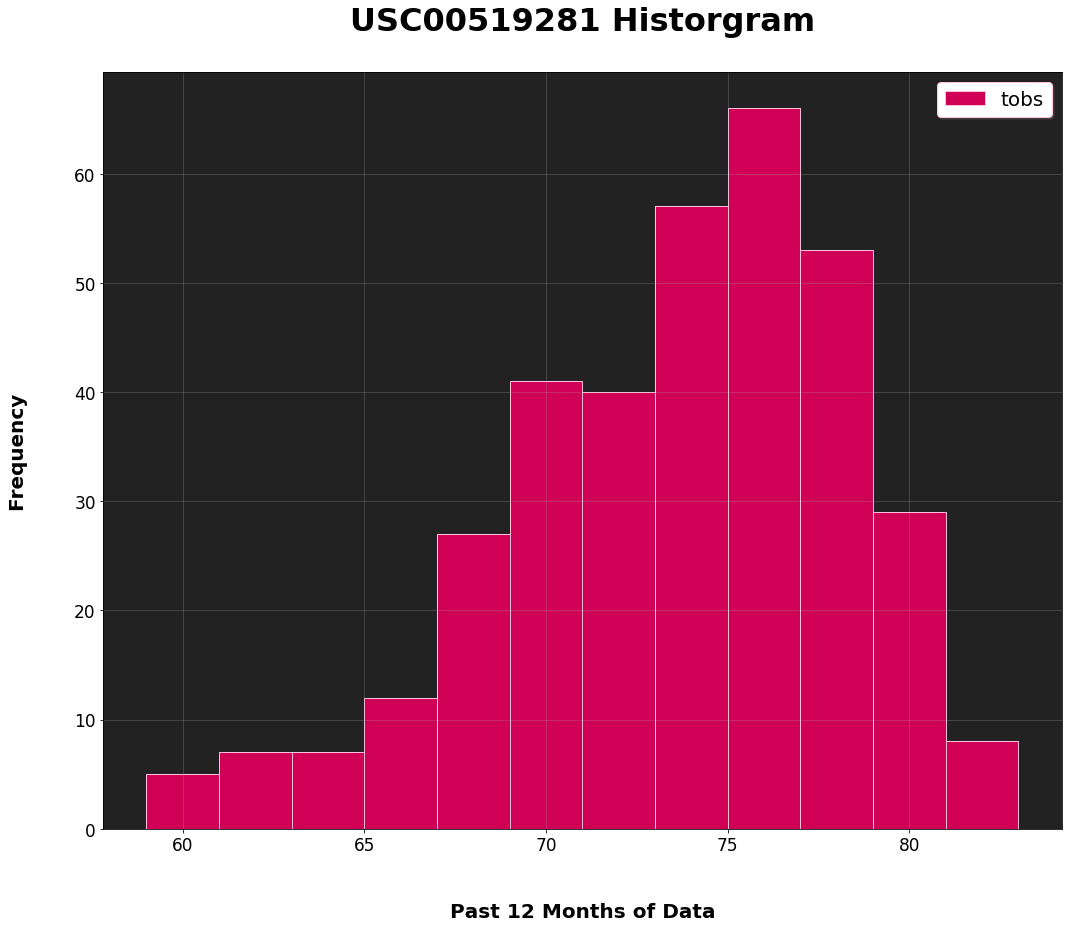

In [54]:
ax = sh_max_df.plot.hist(by=None, bins=12, figsize=(15, 13), color="#CF0055", fontsize=17, edgecolor="#FFC1DA")
ax.set_xlabel(xlabel="\n\nPast 12 Months of Data", fontsize=20, color="#000000", fontweight="bold")
ax.set_frame_on(b=True)
ax.set_facecolor("#222222")
ax.grid(True, alpha=.3)
ax.set_ylabel(ylabel="Frequency\n\n", fontsize=20,fontweight="bold")
ax.legend(frameon=True, fancybox=True, facecolor="#FFFFFF", edgecolor="#FFC1DA", shadow=True, loc="best", fontsize=20, mode="exapnd")
ax.label_outer()
ax.set_title(str(station_max+" Historgram\n"), fontsize=32, color="#000000",fontweight="bold")
plt.tight_layout()
plt.savefig("tobs_histogram.png")

# Temperature Analysis

In [62]:
# Function to accept temperature ranges and return the results of the sql query
def calc_temps(start_date, end_date):
    return session.query(func.min(Measurements.tobs), func.avg(Measurements.tobs), func.max(Measurements.tobs)).\
        filter(Measurements.date >= start_date).filter(Measurements.date <= end_date).all()

In [63]:
max_date = session.query(func.max(Measurements.date)).all()

check = 0
print("Enter your starting and ending dates when prompted:")

#while check == 0:
sd = str(input("\tStart Date in YYYY-MM-DD format: "))
ed = str(input("\tEnd Date in YYYY-MM-DD format: "))
ds= pd.to_datetime(sd,format="%Y-%m-%d", errors="coerce")
de= pd.to_datetime(ed,format="%Y-%m-%d", errors="coerce")
ds_py = ds - dt.timedelta(days=365)
de_py = de - dt.timedelta(days=365)
thres = pa_max_date.toordinal() - de_py.toordinal()
date_value = de.toordinal() - ds.toordinal()
while check == 0:
    if date_value < 0:
        print("Your start date must be before yoru end date")
        check = 0
    else:
        if thres:
            ds_py = ds - dt.timedelta(days=730)
            de_py = de - dt.timedelta(days=730)
        ds_pys = ds_py.strftime("%Y-%m-%d")
        de_pys = de_py.strftime("%Y-%m-%d")
        dates = calc_temps(ds_pys,de_pys)
        check = 1

Enter your starting and ending dates when prompted:
	Start Date in YYYY-MM-DD format: 2017-02-01
	End Date in YYYY-MM-DD format: 2017-02-16


In [64]:
temp_table = pd.DataFrame(np.column_stack([dates]), columns=["Min-Temp","Avg-Temp","Max-Temp"])
temp_table

,Min-Temp,Avg-Temp,Max-Temp
0,56.0,69.462963,79.0


In [65]:
temp_err = temp_table["Max-Temp"]-temp_table["Min-Temp"]
max_temp = session.query(func.max(Measurements.tobs)).all()
temp_upper_lim = int(pd.to_numeric(max_temp[0])) + 20
temp_lower_lim = temp_table["Min-Temp"].sum()-10
temp_avg = temp_table["Avg-Temp"].sum()

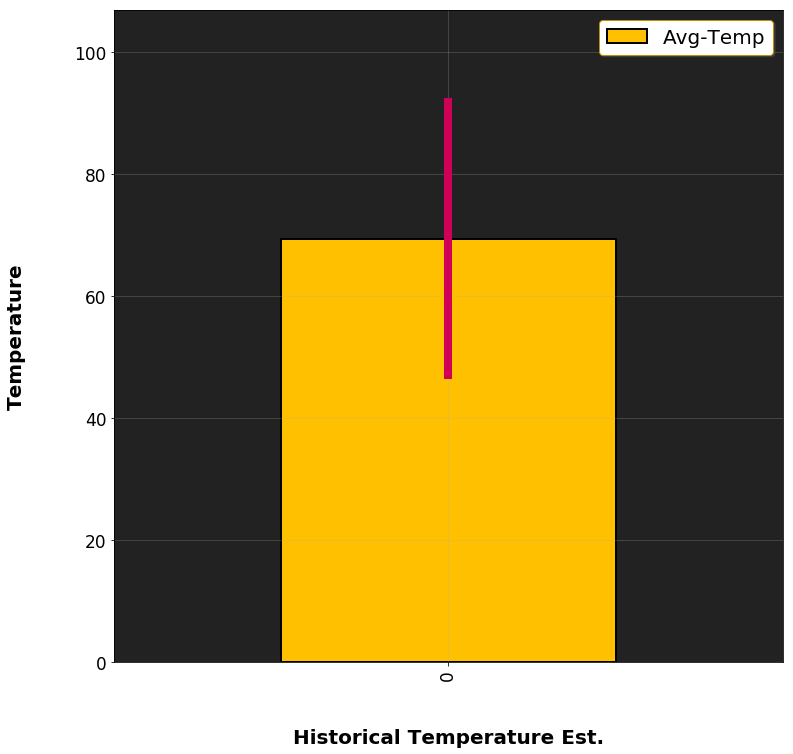

In [66]:
ax = temp_table.plot.bar(y="Avg-Temp", yerr=temp_err, figsize=(12, 12), color="#FFC000", fontsize=17, edgecolor="#010101", linewidth=2)
ax.set_ylim(bottom=0, top = temp_upper_lim)
ax.set_frame_on(b=True)
ax.set_xlabel(xlabel="\n\nHistorical Temperature Est.", fontsize=20, color="#000000", fontweight="bold")
ax.set_facecolor("#222222")
ax.grid(True, alpha=.3)
ax.errorbar(y=temp_avg, x=0, yerr=temp_err, elinewidth=8, ecolor="#CF0055")
ax.set_ylabel(ylabel="Temperature\n\n", fontsize=20,fontweight="bold")
ax.legend(frameon=True, fancybox=True, facecolor="#FFFFFF", edgecolor="#BF8F00", shadow=True, loc="best", fontsize=20, mode="exapnd")